<a href="https://colab.research.google.com/github/namphuongtran9196/ObjectDetectionWithR-CNN/blob/main/Build_R_CNN_(Object_detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import data, lib**

#**About car dataset**
**Overview**

  The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

**Citation**
3D Object Representations for Fine-Grained Categorization
       Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei
       4th IEEE Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.

In [ ]:
!wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz
!gunzip cars_train.tgz

--2021-04-06 06:55:36--  http://imagenet.stanford.edu/internal/car196/cars_train.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  1.55MB/s    in 10m 3s  

2021-04-06 07:05:39 (1.55 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]



In [ ]:
!tar -xf cars_train.tar
!rm cars_train.tar

In [ ]:
!wget http://imagenet.stanford.edu/internal/car196/cars_test.tgz
!gunzip cars_test.tgz

--2021-04-06 06:26:33--  http://imagenet.stanford.edu/internal/car196/cars_test.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘cars_test.tgz’

cars_test.tgz       100%[===================>] 932.07M  3.58MB/s    in 11m 5s  

2021-04-06 06:37:38 (1.40 MB/s) - ‘cars_test.tgz’ saved [977350468/977350468]



In [ ]:
!tar -xf cars_test.tar
!rm cars_test.tar

In [ ]:
!wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
!gunzip car_devkit.tgz

--2021-04-06 06:37:53--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K   977KB/s    in 0.3s    

2021-04-06 06:37:53 (977 KB/s) - ‘car_devkit.tgz’ saved [330960/330960]



In [ ]:
!tar -xf car_devkit.tar
!rm car_devkit.tar

In [ ]:
image = 'cars_train/00001.jpg'

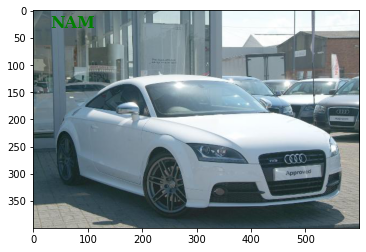

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
img = mpimg.imread(image)
fig, ax = plt.subplots()
ax.imshow(img)
plt.text(30,30,'NAM',fontdict={'family': 'serif',
                                'color':  'green',
                                'weight': 'bold',
                                'size': 16,
                              })
plt.show()

# **Selective search**

In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
img = cv2.imread(image)
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
print(ssresults.shape)
print(ssresults[0])

(2016, 4)
[338 230  37  10]


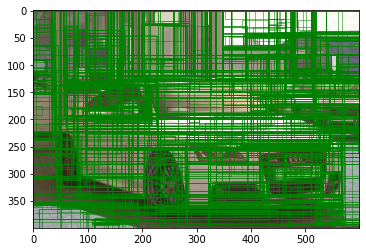

In [ ]:
img = cv2.imread(image)
fig, ax = plt.subplots()
ax.imshow(img)
for i in range(ssresults.shape[0]):
    x,y,w,h = ssresults[i]
    ax.add_patch(Rectangle((x,y),w,h,linewidth=0.5, edgecolor='g',facecolor='none'))   
plt.show()

# **Intersection Over Union (IoU)**
This section shows what IoU do

For more information about Intersection over Union
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

In [ ]:
# import the necessary packages
from collections import namedtuple
import numpy as np
import cv2
# define the `Detection` object
ex = namedtuple("ex", ["image_path", "gt", "pred"])

In [ ]:
def get_IoU(bb_true, bb_pred):
    # determine the (x, y)-coordinates of the intersection rectangle
    x_min = max(bb_true[0], bb_pred[0])
    y_min = max(bb_true[1], bb_pred[1])

    x_max = min(bb_true[2], bb_pred[2])
    y_max = min(bb_true[3], bb_pred[3])

    # check if it does not have intersection rectangle
    if x_max < x_min or y_max< y_min:
        return 0.0
    # compute the area of intersection rectangle
    interArea = (x_max - x_min + 1) * (y_max - y_min + 1)

    # compute the union area
    bbTrueArea = (bb_true[2] - bb_true[0] + 1) * (bb_true[3] - bb_true[1] + 1)
    bbPredArea = (bb_pred[2] - bb_pred[0] + 1) * (bb_pred[3] - bb_pred[1] + 1)

    unionArea = bbTrueArea + bbPredArea - interArea
    # areas - the interesection area
    iou = interArea / unionArea
    # return the intersection over union value
    return iou

In [ ]:
examples = [
	ex(image, [39 ,116 ,569 ,375], [10, 95, 135 ,131]),
	ex(image, [39 ,116 ,569 ,375], [69 ,136 ,469 ,675]),
	ex(image, [39 ,116 ,569 ,375], [39 ,22, 23, 32]),
	ex(image, [39 ,116 ,569 ,375], [39 ,116 ,569 ,375])]

cars_train/00001.jpg: 0.1394


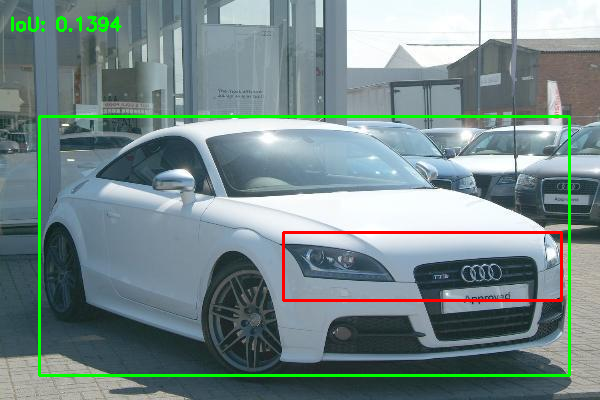

In [ ]:
from google.colab.patches import cv2_imshow
# loop over the example
examples = [
	ex(image, [39 ,116 ,569 ,375],[283, 232, 561, 300])]
for ex in examples:
    # load the image
    img = cv2.imread(image)
    # draw the ground-truth bounding box along with the predicted
    # bounding box
    cv2.rectangle(img, tuple(ex.gt[:2]), 
      tuple(ex.gt[2:]), (0, 255, 0), 2)
    cv2.rectangle(img, tuple(ex.pred[:2]), 
      tuple(ex.pred[2:]), (0, 0, 255), 2)
    # compute the intersection over union and display it
    iou = get_IoU(ex.gt, ex.pred)
    cv2.putText(img, "IoU: {:.4f}".format(iou), (10, 30),
      cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    print("{}: {:.4f}".format(ex.image_path, iou))
    # show the output image
    cv2_imshow(img)
    cv2.waitKey(0)

***An Intersection over Union score > 0.5 is normally considered a “good” prediction. ***

# **Use IoU for classification which is an object and which is a background**


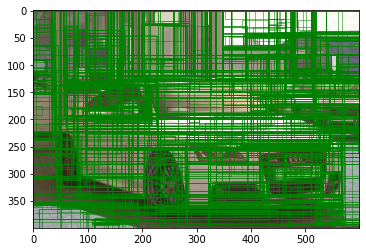

In [ ]:
from google.colab.patches import cv2_imshow
# loop over the example detections
# draw the ground-truth bounding box along with the predicted
# bounding box
fig, ax = plt.subplots()
img = cv2.imread(image)
ax.imshow(img)
for i in range(ssresults.shape[0]):
    x,y,w,h = ssresults[i]   
    if(get_IoU([39 ,116 ,569 ,375],[x,y,x+w,y+h]) >= 0.0):
        ax.add_patch(Rectangle((x,y),w,h,linewidth=0.5, edgecolor='g',facecolor='none'))   
# show the output image
plt.show()

# **Build R-CNN**


In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.io


In [ ]:
mat = scipy.io.loadmat('devkit/cars_train_annos.mat')
mat.items()

dict_items([('__header__', b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013'), ('__version__', '1.0'), ('__globals__', []), ('annotations', array([[(array([[39]], dtype=uint8), array([[116]], dtype=uint8), array([[569]], dtype=uint16), array([[375]], dtype=uint16), array([[14]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
        (array([[36]], dtype=uint8), array([[116]], dtype=uint8), array([[868]], dtype=uint16), array([[587]], dtype=uint16), array([[3]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
        (array([[85]], dtype=uint8), array([[109]], dtype=uint8), array([[601]], dtype=uint16), array([[381]], dtype=uint16), array([[91]], dtype=uint8), array(['00003.jpg'], dtype='<U9')),
        ...,
        (array([[26]], dtype=uint8), array([[246]], dtype=uint8), array([[660]], dtype=uint16), array([[449]], dtype=uint16), array([[163]], dtype=uint8), array(['08142.jpg'], dtype='<U9')),
        (array([[78]], dtype=uint8), array([[526]], dtype

In [ ]:
mat['annotations']

array([[(array([[39]], dtype=uint8), array([[116]], dtype=uint8), array([[569]], dtype=uint16), array([[375]], dtype=uint16), array([[14]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
        (array([[36]], dtype=uint8), array([[116]], dtype=uint8), array([[868]], dtype=uint16), array([[587]], dtype=uint16), array([[3]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
        (array([[85]], dtype=uint8), array([[109]], dtype=uint8), array([[601]], dtype=uint16), array([[381]], dtype=uint16), array([[91]], dtype=uint8), array(['00003.jpg'], dtype='<U9')),
        ...,
        (array([[26]], dtype=uint8), array([[246]], dtype=uint8), array([[660]], dtype=uint16), array([[449]], dtype=uint16), array([[163]], dtype=uint8), array(['08142.jpg'], dtype='<U9')),
        (array([[78]], dtype=uint8), array([[526]], dtype=uint16), array([[1489]], dtype=uint16), array([[908]], dtype=uint16), array([[112]], dtype=uint8), array(['08143.jpg'], dtype='<U9')),
        (array([[20]], dtype=uint8

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
def get_IoU(bb_true, bb_pred):
    assert bb_true[0]<bb_true[2]
    assert bb_true[1]<bb_true[3]
    assert bb_pred[0]<bb_pred[2]
    assert bb_pred[1]<bb_pred[3]
    # determine the (x, y)-coordinates of the intersection rectangle
    x_min = max(bb_true[0], bb_pred[0])
    y_min = max(bb_true[1], bb_pred[1])

    x_max = min(bb_true[2], bb_pred[2])
    y_max = min(bb_true[3], bb_pred[3])
    # check if it does not have intersection rectangle
    if x_max < x_min or y_max< y_min:
        return 0.0
    # compute the area of intersection rectangle
    interArea = (x_max - x_min + 1) * (y_max - y_min + 1)
    # compute the union area
    bbTrueArea = (bb_true[2] - bb_true[0] + 1) * (bb_true[3] - bb_true[1] + 1)
    bbPredArea = (bb_pred[2] - bb_pred[0] + 1) * (bb_pred[3] - bb_pred[1] + 1)
    unionArea = float(bbTrueArea + bbPredArea - interArea)
    # areas - the interesection area
    iou = interArea / unionArea
    # return the intersection over union value
    assert iou <= 1.0
    return iou

In [ ]:
train_images = []
train_labels = []
train_Data =np.sort(np.array(os.listdir('cars_train')))
bbox_x1,bbox_y1 = mat['annotations']['bbox_x1'],mat['annotations']['bbox_y1']
bbox_x2,bbox_y2 = mat['annotations']['bbox_x2'],mat['annotations']['bbox_y2']

import sys
from tqdm import tqdm
with tqdm(total=50, file=sys.stdout) as pbar:
  for i,filename in enumerate(train_Data):
      file_path = 'cars_train/' + filename
      img = cv2.imread(file_path)
      bbox_true = [float(bbox_x1[0,i]),float(bbox_y1[0,i]),float(bbox_x2[0,i]),float(bbox_y2[0,i])]
      ss.setBaseImage(img)
      ss.switchToSelectiveSearchFast()
      ssresults = ss.process()
      temp_img = img.copy()
      true_counter = 0
      false_counter = 0
      for j,result in enumerate(ssresults):
          if j>1000:
              break
          x,y,w,h = result
          iou = get_IoU(bbox_true,[x,y,x+w,y+h])
          if true_counter <=30 and iou >= 0.75:
              img_train = temp_img[y:y+h,x:x+w]
              resized = cv2.resize(img_train,(224,224))
              train_images.append(resized)
              train_labels.append(1)
              true_counter+=1
          elif false_counter<=30 and iou<=0.3:
              img_train = temp_img[y:y+h,x:x+w]
              resized = cv2.resize(img_train,(224,224))
              train_images.append(resized)
              train_labels.append(0)
              false_counter+=1
          if true_counter > 30 and false_counter >30:
              break
      pbar.update(1)
      if i>50:
            break
      

52it [11:52, 13.71s/it]


In [ ]:
# !gdown --id 1G5QVNPMnwMdasYHThJfr_Lv1BRqkoWhs
# !gdown --id 1AUjaoywYznisy7LnnlLiTDwXO6oZgknx

In [ ]:
i =0
for item in train_labels:
    if item ==1:
        i+=1
        print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


In [ ]:
train_x = np.array(train_images)
train_y = np.array(train_labels)

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

BATCH_SIZE = 128
EPOCHS = 8

In [ ]:
from sklearn.model_selection import train_test_split
y_ohe = tf.keras.utils.to_categorical(train_y, num_classes=2)
x_train, x_valid, y_train_ohe, y_valid_ohe = train_test_split(train_x, y_ohe, test_size=0.2)

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip = True, vertical_flip= True, rotation_range = 90)
train_data = train_datagen.flow(x = x_train, y = y_train_ohe,batch_size=BATCH_SIZE)

In [ ]:
vgg16 = VGG16(input_shape=(224,224,3),weights = 'imagenet', include_top=False)

for layers in vgg16.layers:
    layers.trainable = False

x = tf.keras.layers.Flatten()(vgg16.output)
x = tf.keras.layers.Dense(units=4096,activation="relu")(x)
x = tf.keras.layers.Dense(units=4096,activation="relu")(x)
predictions = tf.keras.layers.Dense(units=2, activation = 'softmax')(x)

model = Model(inputs = vgg16.input, outputs = predictions)
mcp = tf.keras.callbacks.ModelCheckpoint("my_model.h5", monitor="val_accuracy",
                      save_best_only=True, save_weights_only=True)
model.compile(Adam(0.001), loss='categorical_crossentropy',
                  metrics=['accuracy'])
model.fit_generator(generator = train_data, epochs= EPOCHS,
              validation_data=(x_valid, y_valid_ohe), verbose=1, callbacks=[mcp])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
11/11 [==============================] - 887s 81s/step - loss: 72.5926 - accuracy: 0.7707 - val_loss: 0.4862 - val_accuracy: 0.9645
Epoch 2/8
11/11 [==============================] - 885s 82s/step - loss: 0.2789 - accuracy: 0.9798 - val_loss: 0.0614 - val_accuracy: 0.9970
Epoch 3/8
11/11 [==============================] - 881s 81s/step - loss: 0.8914 - accuracy: 0.9931 - val_loss: 0.0594 - val_accuracy: 0.9882
Epoch 4/8
11/11 [==============================] - 880s 81s/step - loss: 4.8226 - accuracy: 0.9977 - val_loss: 0.0540 - val_accuracy: 0.9970
Epoch 5/8
11/11 [==============================] - 881s 81s/step - loss: 0.0166 - accuracy: 0.9975 - val_loss: 0.0526 - val_accuracy: 0.9970
Epoch 6/8
11/11 [==============================] - 881s 81s/step - loss: 0.0048 - accuracy: 0.9969 - val_loss: 0.0856 - val_accuracy: 0.9970
Epoch 7/8
11/11 [==============================] - 887s 81s/step - loss: 0.0109 - accuracy: 0.9944 - val_loss: 0.1208 - val_accuracy: 0.9941
Epoch 8/8
11

# PREDICTION

In [ ]:
device = '/cpu:0' if len(tf.config.experimental.list_physical_devices('GPU')) == 0 else '/gpu:0'
with tf.device(device):
    model.load_weights("my_model.h5")

In [ ]:
image_test = 'cars_test/00002.jpg'
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
img = cv2.imread(image_test)
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
img_temp = img.copy()
import sys
from tqdm import tqdm
with tqdm(total=len(ssresults), file=sys.stdout) as pbar:
    for i, results in enumerate(ssresults):
        if i<2000:
            x,y,w,h = results
            img_predict = img_temp[y:y+h, x:x+w]
            resized = cv2.resize(img_predict,(224,224))
            resized = np.expand_dims(resized, axis=0)
            predictions = model.predict(resized)
            if (predictions[0][1] >= 0.5):
                cv2.rectangle(img_temp,(x,y),(x+w,y+h),(0,255,0),1,cv2.LINE_AA)
        pbar.update(1)
plt.figure()
plt.imshow(img_temp)

 29%|██▉       | 617/2110 [06:16<22:14,  1.12it/s]